In [2]:
import math
import torch
import gpytorch

import matplotlib.pyplot as plt
import numpy as np

# NN kernel

- non-stationary and good for discontinuities
- imitates one layer of NN

## Replicate Rasmussen Figure 4.5 page 92

- to check that my implementation is correct
- Rasmussen definition: 
  

    -  x_dash^T needs to be 1 X (D+1)
    -  x_dash needs to be (1+D) X 1 (a column vector e.g. 2x1)
    -  Sigma is (1+D) X (1+D)
    - [1 X (D+1)] X [(1+D) X (1+D)] X [(1+D) X 1] so that 1 X 1
    - vector notation, not matrices

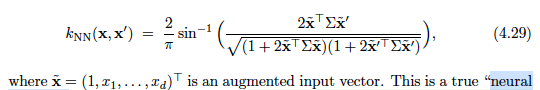

- Rasmussen plot:   
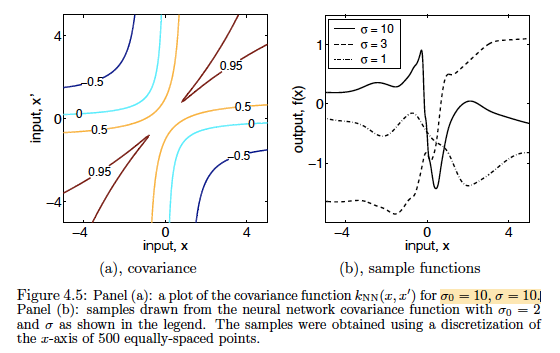  


# Vector notation

- We compute each covariance matrix entry one at the time, following Rasmusses's vector notation

In [3]:
N = 9
N = 500
K_NN_output = torch.empty(N, N)

x_tensor = torch.linspace(-4, 4, N)
x_tensor_aug = torch.cat((torch.ones(N, 1), x_tensor.unsqueeze(-1)), dim = 1)
lengthscales = torch.tensor([10.**2, 10.**2])

for i in range(N):
    for j in range(N):
        x_vector = x_tensor_aug[i,]
        x_vector_dash = x_tensor_aug[j,]

        x_vector_scaled = x_vector.mul(lengthscales).unsqueeze(-1)
        x_vector_dash_scaled = x_vector_dash.mul(lengthscales).unsqueeze(-1)

        XXdash_2 = torch.matmul(x_vector_scaled.T, x_vector_dash_scaled) * 2
        XX_2 = torch.matmul(x_vector_scaled.T, x_vector_scaled) * 2
        XdashXdash_2 = torch.matmul(x_vector_dash_scaled.T, x_vector_dash_scaled) * 2

        denom = torch.sqrt(torch.mul((1 + XX_2), (1 + XdashXdash_2)))
        input = torch.div(XXdash_2, denom)

        K_NN_output[i, j] = torch.asin(input) * 2/math.pi

Text(0.5, 1.0, 'We almost reproduce Rasmussen')

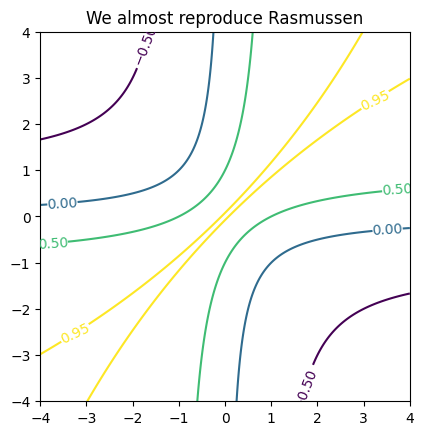

In [83]:
X, Y = np.meshgrid(np.linspace(-4, 4, N), np.linspace(-4, 4, N))

fig, ax = plt.subplots()
CS = ax.contour(X, Y, K_NN_output, levels = [-0.5, 0, 0.5, 0.95])
ax.clabel(CS, inline = True, fontsize = 10)
ax.set_aspect('equal', adjustable = 'box')
ax.set_title('We almost reproduce Rasmussen')

# Tensorise

- many element-wise operations
- much faster than for loop

In [81]:
# keep N small to visualise K_NN (N = 9) or make N = 500 for contour plot
N = 500

N1 = N
N2 = N

# toy data 
x1_tensor = torch.linspace(-4, 4, N1)
x2_tensor = torch.linspace(-4, 4, N2)

# Augment the input with ones to get the bias term
x1_tensor_aug = torch.cat((torch.ones(N1, 1), x1_tensor.unsqueeze(-1)), dim = 1)
x2_tensor_aug = torch.cat((torch.ones(N2, 1), x2_tensor.unsqueeze(-1)), dim = 1)

# as in Rasmussen: sigma 0 (std) and sigma (std) = 10 given
lengthscales = torch.tensor([10., 10.]) ** 2

# Scaling thus we use torch.mul instead of torch.matmul
# [N x 2] (a collection of row vectors) mul [2]
x1_tensor_aug_scaled = torch.mul(x1_tensor_aug, lengthscales)
x2_tensor_aug_scaled = torch.mul(x2_tensor_aug, lengthscales)

# We want this output to be quadtratic (pairwise) N x N (Transposing now is counter intuitive)
# Column vector has N rows so here we transpose the second element.
# Still fine numerically
numerator = torch.sum(
    torch.mul(
        x1_tensor_aug.unsqueeze(1).repeat(1, N2, 1),
        x2_tensor_aug_scaled.unsqueeze(0).repeat(N1, 1, 1)), 
        dim = -1) * 2

# copy for all N2 X2's
x1x1_2dot = torch.sum(
    torch.mul(
        x1_tensor_aug,
        x1_tensor_aug_scaled), 
        dim = -1).unsqueeze(-1).repeat(1, N2) * 2

x2x2_2dot = torch.sum(
    torch.mul(
        x2_tensor_aug,
        x2_tensor_aug_scaled), 
        dim = -1).unsqueeze(0).repeat(N1, 1) * 2

# elementwise multiplication, elementwise sqrt
denominator = torch.sqrt(torch.mul((1 + x1x1_2dot), (1 + x2x2_2dot)))

# input argument to arcsin
arcsin_argument = torch.div(numerator, denominator)

# Arcsin maps from pi to -pi/2
# CLAMP: arcsin can only take inputs between -1 and 1
arcsin_input_clamped = arcsin_argument.clamp(-1, 1)

# K_NN = torch.asin(arcsin_input_clamped)
K_NN = torch.asin(arcsin_input_clamped) * 2 / math.pi

Text(0.5, 1.0, 'We reproduce Rasmussens results')

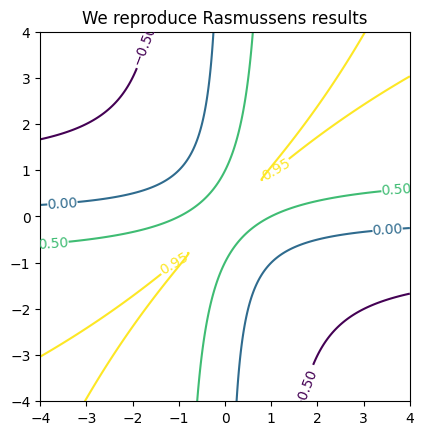

In [82]:
X, Y = np.meshgrid(np.linspace(-4, 4, N), np.linspace(-4, 4, N))

fig, ax = plt.subplots()
CS = ax.contour(X, Y, K_NN, levels = [-0.5, 0, 0.5, 0.95])
ax.clabel(CS, inline = True, fontsize = 10)
ax.set_aspect('equal', adjustable = 'box')
ax.set_title('We reproduce Rasmussens results')

## Incorrect version

## Function wrapper

Draws samples so we don't need this.

In [84]:
def NN_kernel(x1_tensor, x2_tensor, lengthscales_std):
    """_summary_

    Args:
        x1_tensor (N1 X D): Input tensor one
        x2_tensor (N2 X D): Input tensor two
        lengthscales_std (D+1): bias and D lengthscales

    Returns:
        K_NN (N1 X N2): covariance matrix
    """
    # square std to get variance
    lengthscales = lengthscales_std ** 2

    # Extract dimensionalities
    N1 = x1_tensor.size(0)
    N2 = x2_tensor.size(0)

    # Augment the input with ones for the bias term
    x1_tensor_aug = torch.cat((torch.ones(N1, 1), x1_tensor.unsqueeze(-1)), dim = 1)
    x2_tensor_aug = torch.cat((torch.ones(N2, 1), x2_tensor.unsqueeze(-1)), dim = 1)

    # Scale both tensors with lengthscale Sigma (torch.mul instead of torch.matmul for scaling)
    # Scaling: [N x (D+1)] (a collection of row vectors) mul [D+1]
    x1_tensor_aug_scaled = torch.mul(x1_tensor_aug, lengthscales)
    x2_tensor_aug_scaled = torch.mul(x2_tensor_aug, lengthscales)

    # We want this output to be quadtratic (pairwise) N1 x N2
    # Dot product of all pairs of x1 and x2: elementwise multiplication followed by summing away the dimensions
    numerator = torch.sum(
        torch.mul(
            x1_tensor_aug.unsqueeze(1).repeat(1, N2, 1),
            x2_tensor_aug_scaled.unsqueeze(0).repeat(N1, 1, 1)), 
            dim = -1) * 2

    # copy for all N2 X2's
    x1x1_2dot = torch.sum(
        torch.mul(
            x1_tensor_aug,
            x1_tensor_aug_scaled), 
            dim = -1).unsqueeze(-1).repeat(1, N2) * 2

    x2x2_2dot = torch.sum(
        torch.mul(
            x2_tensor_aug,
            x2_tensor_aug_scaled), 
            dim = -1).unsqueeze(0).repeat(N1, 1) * 2

    # elementwise multiplication, elementwise sqrt
    denominator = torch.sqrt(torch.mul((1 + x1x1_2dot), (1 + x2x2_2dot)))

    # input argument to arcsin: elementwise division
    arcsin_argument = torch.div(numerator, denominator)

    # Arcsin maps from pi to -pi/2
    # CLAMP: arcsin can only take inputs between -1 and 1 (not needed)
    arcsin_input_clamped = arcsin_argument.clamp(-1, 1)

    # Scale by 2/pi to get the correct range
    K_NN = torch.asin(arcsin_input_clamped) * 2 / math.pi

    return K_NN

In [89]:
# Test with small N
N = 7

# toy data 
x_tensor = torch.linspace(-3, 3, N)

lengthscales_std_10_10 = torch.tensor([10, 10])

NN_kernel(x_tensor, x_tensor, lengthscales_std_10_10)

tensor([[ 0.9799,  0.9064,  0.7029,  0.2043, -0.2947, -0.4995, -0.5899],
        [ 0.9064,  0.9715,  0.7919,  0.2942, -0.2045, -0.4092, -0.4995],
        [ 0.7029,  0.7919,  0.9550,  0.4976,  0.0000, -0.2045, -0.2947],
        [ 0.2043,  0.2942,  0.4976,  0.9365,  0.4976,  0.2942,  0.2043],
        [-0.2947, -0.2045,  0.0000,  0.4976,  0.9550,  0.7919,  0.7029],
        [-0.4995, -0.4092, -0.2045,  0.2942,  0.7919,  0.9715,  0.9064],
        [-0.5899, -0.4995, -0.2947,  0.2043,  0.7029,  0.9064,  0.9799]])

### Vasudevan, Shrihari, et al. "Gaussian process modeling of large‐scale terrain." Journal of Field Robotics 26.10 (2009): 812-840

In Vasudevan et al. 2009 is is 

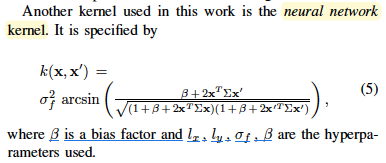

The formulations looks different because: 
- x is not augmented 
- The bias is defined outside of inner product

The lengthscale is parametised differently here, as an inverse std term:  
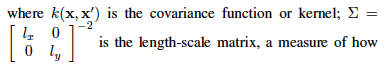

# Implement as custom kernel in GPytorch

https://docs.gpytorch.ai/en/v1.7.0/examples/00_Basic_Usage/Implementing_a_custom_Kernel.html

In [ ]:
NeuralNetworkKernel().forward(mb_train_x, mb_train_x)

In [ ]:
# https://docs.gpytorch.ai/en/v1.7.0/examples/00_Basic_Usage/Implementing_a_custom_Kernel.html
class NeuralNetworkKernel(gpytorch.kernels.Kernel):
    # Following Rasmussen's notation

    has_lengthscale = True

    def forward(self, x1, x2, **params):
        # x1 is vector?
        
        # Apply lengthscale transform
        x1_ = x1.div(self.lengthscale)
        x2_ = x2.div(self.lengthscale)

        # Inner product term
        x1_innerprod = torch.matmul(x1.T, x1_) * 2

        # x dash
        x2_innerprod = torch.matmul(x2.T, x2_) * 2

        x1_x2_innerprod = torch.matmul(x1.T, x2_) * 2

        denom = torch.linalg.inv(torch.matmul(((x2_innerprod * 2) + 1), (x1_innerprod + 1)))

        kernel_matrix = torch.arcsin(torch.div(x1_x2_innerprod, denom))

        return kernel_matrix

In [ ]:
import torch
import gpytorch
from gpytorch.kernels import Kernel

class NeuralNetworkKernel(Kernel):
    def __init__(self, **kwargs):
        super(NeuralNetworkKernel, self).__init__(**kwargs)

    def forward(self, x1, x2, **params):
        # Add bias (corresponds to input variance of 1)
        x1 = torch.cat([x1, torch.ones(x1.size(0), 1).to(x1)], dim=-1)
        x2 = torch.cat([x2, torch.ones(x2.size(0), 1).to(x2)], dim=-1)
        
        # Compute dot product and normalize it
        x1_norm = torch.sqrt((x1 ** 2).sum(dim=-1, keepdim=True))
        x2_norm = torch.sqrt((x2 ** 2).sum(dim=-1, keepdim=True))
        
        inner_prod = torch.matmul(x1, x2.T) / (x1_norm * x2_norm.T + 1e-6)
        inner_prod = inner_prod.clamp(-1, 1)  # Ensure values are within the valid range of acos
        
        # Compute the angle theta
        theta = torch.acos(inner_prod)
        
        # Arc-cosine kernel from Rasmussen
        kernel_matrix = (torch.sin(theta) + (torch.pi - theta) * torch.cos(theta)) / torch.pi
        
        return kernel_matrix

# Example usage
input_dim = 5  # Assuming 5 input features
kernel = NeuralNetworkKernel()

# Suppose x1 and x2 are two input tensors of shape [n_samples, input_dim]
x1 = torch.randn(10, input_dim)
x2 = torch.randn(10, input_dim)

# Compute the kernel matrix
kernel_matrix = kernel(x1, x2)
print(kernel_matrix)